In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import seaborn as sns
import matplotlib.pyplot as plt

tfd = tfp.distributions

2023-02-05 16:07:42.221027: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Perhaps the most useful (or utilized) probability model for data analysis is the normal distribution. There are several reasons for this, one being the central limit theorem, and another being that the normal model is a simple model with separate parameters for the population mean and variance - two quantities that are often of primary interest. In this chapter we discuss some of the properties of the normal distribution, and show how to make posterior inference on the population mean and variance parameters. We also compare the sampling properties of the standard Bayesian estimator of the population mean to those of the unbiased sample mean. Lastly, we discuss the appropriateness of the normal model when the underlaying data are not normally distributed.

### The normal model

A random variable Y is sadi to be normally distributed with mean $\mu$ and variance $\sigma^2$ > 0 if the density of Y is given by

$$ p(y|\mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{1}{2}(\frac{y - \mu}{\sigma})^2} $$

Figure below shows normal density curves for a few values of $\mu$ and $\sigma^2$. Some important things to remember about this distribution include that:

- the distribution is symmetric about $\mu$, and the mode, median and mean are all equal to $\mu$.
- about 95% of the population lies within two standard deviations of the mean (more precisely, 1.96 standard deviations).
- if $X \sim normal(\mu, \tau^2), Y \sim normal(\theta, \sigma^2)$ and X and Y are independent, then $aX + bY \sim normal(a\mu + b\theta, a^2\tau^2 + b^2\sigma^2)$.

In [2]:
def normal_distribution(mu_, sigma_):
    return tfd.Normal(loc=mu_, scale=sigma_)

normal_dis_ex_1 = normal_distribution(mu_=[2, 5, 7], sigma_=[0.25, 4, 1])
normal_dis_prob_samples = normal_dis_ex_1.sample(1000)

Metal device set to: AMD Radeon Pro 5500M


2023-02-05 16:08:32.644515: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-05 16:08:32.647003: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-05 16:08:32.647089: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-05 16:08:32.647607: I tensorflow/core/common_runtime/pluggable_device/plug

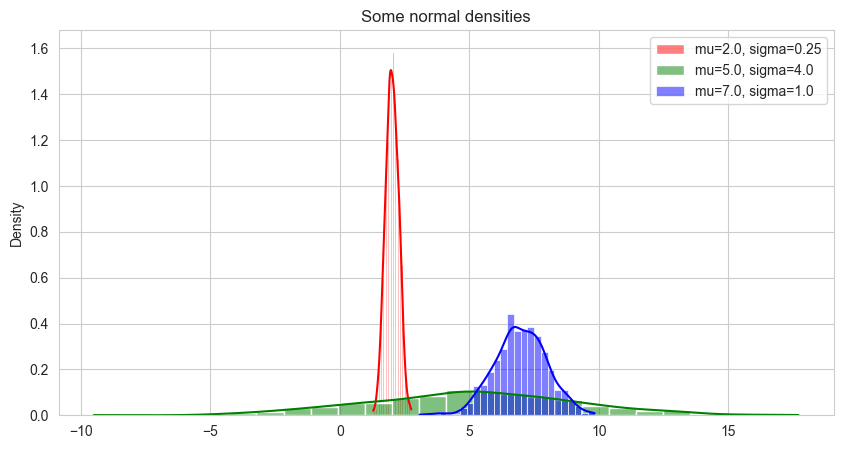

In [3]:
_, normal_ax_example = plt.subplots(1, 1, figsize=(10, 5))

colors_ = ["red", "green", "blue"]
for i in range(3):
    sns.histplot(normal_dis_prob_samples[:, i], ax=normal_ax_example, kde=True, stat="density", label=f"mu={normal_dis_ex_1.loc[i].numpy()}, sigma={normal_dis_ex_1.scale[i].numpy()}", color=colors_[i])

plt.legend()
plt.title("Some normal densities")
plt.show()

The importance of the normal distribution stems primarily from the central limit theorem, which says that under very general conditions, the sum (or mean) of a set of random variables is approximately normally distributed. In practice, this means that the normal sampling model will be appropriate for data that result from the additive effects of a large number of factors.

##### Example: women's height

A study of 1100 English families from 1893 to 1898 gathered height data on $n=1375$ women over the age of 18. A histogram of these data in shown figure below. The sample mean of these data is $\overline{y}=63.75$ and the sample standard deviation is $s=2.62$ inches. One explanation for the variability in heights among these women is that the women were heterogeneous in terms of a number of factors controlling human growth, such as genetics, diet, disease, stress and so on. Variability in these factors among the women results in variability in their heights. Letting $y_{i}$ be the height in inches of women $i$, a simple additive model for height might be

$$ y_{1} = a + b*gene_{1} + c*diet_{1} + d*disease_{1} + ...$$
$$ y_{2} = a + b*gene_{2} + c*diet_{2} + d*disease_{2} + ...$$
$$...$$
$$ y_{n} = a + b*gene_{n} + c*diet_{n} + d*disease_{n} + ...$$

where $gene_{i}$ might denote the presence of a particular height-promoting gene, $diet_{i}$ might measure some aspect of women i's diet, and $disease_{i}$ might indicate if women i had ever had a particular disease. Of course, there may be a large number of genes, diseases, dietary and other factors that contribute to a women's height. If the effects of these factors are approximately additive, then each height measurement $y_{i}$ is roughly equal to linear combination of a large number of terms. For such situations, the central limit theorem says that the empirical distribution of $y_{1},...,y_{n}$ will look like a normal distribution, and so the normal model provides an appropriate sampling model for the data.

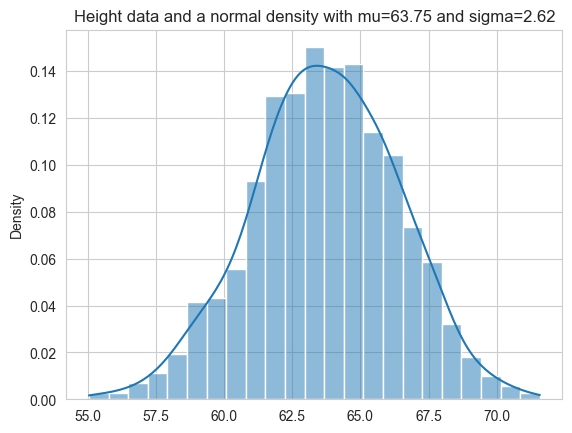

In [7]:
height_distribution = normal_distribution(63.75, 2.62)
height_samples = height_distribution.sample(1000)

sns.histplot(height_samples, kde=True, stat="density")
plt.title("Height data and a normal density with mu=63.75 and sigma=2.62")
plt.show()

### Inference for the mean, conditional on the variance

Suppose our model is ${Y_{i}, ..., Y_{n}|\theta, \sigma^2} \sim normal(\theta, \sigma^2)$. Then the joint sampling density is given by

$$ p(y_{1},...,y_{n}|\theta, \sigma^2) = \prod_{i=1}^{n} p(y_{i}|\theta, \sigma^2) = \prod_{i=1}^{n} \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{1}{2}(\frac{y_{i} - \theta}{\sigma} ^ 2)} $$

Expanding the quadratic term in the exponent, wee see that $p(y_{1},...,y_{n}|\theta, \sigma^2)$ depends on $y_{1},...,y_{n}$ through

$\sum_{i=1}^{n} (\frac{y_{i} - \theta}{\sigma}^2) = \frac{1}{\sigma^2}\sum y_{i}^2 - 2\frac{\theta}{\sigma^2}\sum y_{i} + n\frac{\theta^2}{\sigma^2}$

From this you can show that $(\sum y_{i}^2, \sum y_{i})$ make up a two-dimensional sufficient statistic. Knowing the values of these quantities is equivalent to knowing the values of $\overline{y}=\sum y_{i}/n$ and $s^2 = \sum (y_{i} - \overline{y})^2/(n-1)$, and so $(\overline{y}, s^2)$ are also a sufficient statistic.
Inference for this two-parameter model can be broken down into two one-parameter problems. We will begin with the problem of making inference for $\theta$ when $\sigma^2$ is known, and use a conjugate prior distribution for $\theta$. For any (conditional) prior distribution $p(\theta|\sigma^2)$, the posterior distribution will satisfy

$p(\theta|y_{1},...,y_{n},\sigma^2) \propto p(\theta|\sigma^2) e^{-\frac{1}{2\sigma^2}\sum (y_{i}-\theta)^2} \propto p(\theta|\sigma^2) e^{c_{1}(\theta - c_{2})^2}$

Recall that a class of prior distributions is conjugate for a sampling model if the resulting posterior distribution is in the same class. From the calculation above, we see that if $p(
theta|\sigma^2)$ is to be conjugate, it must include quadratic terms like $e^{c_{1}(\theta - c_{2})^2}$. The simplest such class of probability densities on \mathbb{R} is the normal family of densities, suggesting that if $p(\theta|\sigma^2)$ is normal and $y_{1},...,y_{n}$ are iid normal($\theta,\sigma^2$), then $p(\theta|y_{1},...,y_{n},\sigma^2)$ is also a normal density. Let's evaluate this claim:
If $\theta \sim normal(\mu_{0}, \tau_{0}^2)$, then

$$p(\theta|y_{1},...,y_{n},\sigma^2) = p(\theta|\sigma^2)p(y_{1},...,y_{n}|\theta,\sigma^2) / p(y_{1},...,y_{n}|\sigma^2) \propto p(\theta|\sigma^2)p(y_{1},...,y_{n}|\theta, \sigma^2) \propto exp(-\frac{1}{2\tau_{0}^2}(\theta - \mu_{0}^2))exp(-\frac{1}{2\sigma^2}\sum(y_{i} - \theta)^2)$$

Adding the terms in the exponents and ignoring the $-\frac{1}{2}$ for the moment, we have

$\frac{1}{\tau_{0}^2}(\theta^2 - 2\theta\mu_{0} + \mu_{0}^2) + \frac{1}{\sigma^2}(\sum y_{i}^2 - 2\theta\sum y_{i} + n\theta^2) = a\theta^2 - 2b\theta + c$ where $a=\frac{1}{\tau_{0}^2} + \frac{n}{\sigma^2}$, $b=\frac{\mu_{0}}{\tau_{0}^2} + \frac{\sum y_{i}}{\sigma^2}$ and $c=c(\mu_{0}, \tau_{0}^2, \sigma^2, y_{1},...,y_{n})$.

Now let's see if $p(\theta|\sigma^2,y_{1},...,y_{n}) \propto exp(-\frac{1}{2}(a\theta^2 - 2b\theta))=exp(-\frac{1}{2}a(\theta^2 - 2b\theta/a + b^2/a^2) + \frac{1}{2}b^2/a) \propto exp(-\frac{1}{2}a(\theta - b/a)^2) = exp(-\frac{1}{2}(\frac{\theta - b/a}{1/\sqrt{a}})^2)$

This function has exactly the same shape as a normal density curve, with $1/\sqrt(a)$ playing the role of the standard deviation and b/a playing the role of the mean. Since probability distributions are determined by their shape, this means that $p(\theta | \sigma^2, y_{1},...,y_{n})$ is indeed a normal density. We refer to the mean and variance of this density as $\mu_{n}$ and $\tau_{n}^2$, where

$
\tau_{n}^2 = \frac{1}{a} = \frac{1}{\frac{1}{\tau_{0}^2} + \frac{n}{\sigma^2}}
$ and $
\mu_{n} = \frac{b}{a} = \frac{\frac{1}{\tau_{0}^2}\mu_{0} + \frac{n}{\sigma^2}\overline{y}}{\frac{1}{\tau_{0}^2} + \frac{n}{\sigma^2
$

##### Combining information

The (conditional) posterior parameters $\tau_{n}^2$ and $\mu_{n}$ combine the prior parameters $\tau_{0}^2$ and $\mu_{0}$ with terms from the data.

- Posterior variance and precision: The formula for $\frac{1}{\tau_{n}^2}$ is
      $\frac{1}{\tau_{n}^2} = \frac{1}{\tau_{0}^2} + \frac{n}{\sigma^2}$             (5.1)
  and so the prior inverse variance is combined with the inverse of the data variance. Inverse variance is often referred to as the precision. For the normal model let,
      $\widetilde{\sigma^2} = 1/\sigma^2$ = sampling precision, i.e. how close the $y_{i}$ are to $\theta$
      $\widetilde{\tau_{0}^2} = 1/\tau_{0}^2$ = prior precision
      $\widetilde{\tau_{n}^2} = 1/\tau_{n}^2$ = posterior precision
  It is convenient to think about precision as the quantity of information on additive scale.For the normal model, Equation 5.1 implies that $\widetilde{\tau_{n}^2} = \widetilde{\tau_{0}^2} + n\widetilde{\sigma^2}$
  and so posterior information = prior information + data information
- Posterior mean: Notice that
       $\mu_{n} = \frac{\widetilde{\tau_{0}^2}}{\widetilde{\tau_{0}^2} + n\widetilde{\sigma^2}}\mu_{0} + \frac{n\widetilde{\sigma^2}}{\widetilde{\tau_{0}^2} + n\widetilde{\sigma^2}}\overline{y}$
  and so the posterior mean is weighted average of the prior mean and the sample mean. The weight on the sample mean is $n/\sigma^2$, the sampling precision of the sample mean. The weight on the prior mean is $1/\tau_{0}^2$, the prior precision. If the prior mean were based on $\kappa_{0}$ prior observations from the same (or similar) population as $Y_{1},...,Y_{n}$, then we might want to set $\tau_{0}^2 = \sigma^2/\kappa_{0}$, the variance of the mean of the prior observations. In this case, the formula for the posterior mean reduces to
  $$ \mu_{n} = \frac{\kappa_{0}}{\kappa_{0} + n}\mu_{0} + \frac{n}{\kappa_{0} + n}\overline{y}$$

#### Prediction

Consider predicting a new observation $\widetilde{Y}$ from the population after having observed ($Y_{1}=y_{1},...,Y_{n}=y_{n}$). To find the predictive distribution, let's use the following fact:

$$
{\widetilde{Y}| \theta, \sigma^2} \sim normal(\theta, \sigma^2) \Leftrightarrow \widetilde{Y} = \theta + \widetilde{\epsilon}, (\widetilde{\epsilon} | \theta, \sigma^2) \sim normal(0, \sigma^2)
$$

In other words, saying that $\widetilde{Y}$ is normal with mean $\theta$ is the same as saying $\widetilde{Y}$ is equal to $\theta$ plus some mean-zero normally distributed noise. Using this result, let's first compute the posterior mean and variance of $\widetilde{Y}$:

$$
E[\widetilde{Y} | y_{1},...,y_{n}, \sigma^2] = E[\theta + \widetilde{\epsilon} | y_{1},...,y_{n}, \sigma^2] = E[\theta | y_{1},...,y_{n}, \sigma^2] + E[\widetilde{\epsilon} | y_{1},...,y_{n}, \sigma^2] = \mu_{n} + 0 = \mu_{n}
$$

$$
Var[\widetilde{Y} | y_{1},...,y_{n},\sigma^2] = Var[\theta + \widetilde{epsilon} | y_{1},...,y_{n},\sigma^2] = Var[\theta | y_{1},...,y_{n},\sigma^2] + Var[\widetilde{\epsilon} | y_{1},...,y_{n},\sigma^2] = \tau_{n}^2 + \sigma^2 = \frac{1}{\frac{1}{\tau_{0}^2} + \frac{n}{\sigma^2}} + \sigma^2
$$

Recall from the beginning of the chapter that the sum of independent normal random variables is also normal. Therefore, since both $\theta$, $\widetilde{\epsilon}$, conditional on $y_{1},...,y_{n}$ and $\sigma^2$, are normally distributed, so is $\widetilde{Y} = \theta + \widetilde{\epsilon}$. The predictive distribution is therefore

$$
\widetilde{Y} | \sigma^2, y_{1},...,y_{n} \sim normal(\mu_{n}, \tau_{n}^2 + \sigma^2)
$$

It is worthwhile to have some intuition about the form of the variance of $\widetilde{Y}$: In general, our uncertainty about a new sample $\widetilde{Y}$ is a function of our uncertainty about the center of the population ($\tau_{n}^2$) as well as how variable the population is (\sigma^2). As $n \Rightarrow \infty$ we become more and more certain about where $\theta$ is, and the posterior variance $\tau_{n}^2$ of $\theta$ goes to zero. But certainty about $\theta$ does not reduce the sampling variability $\sigma^2$, and so our uncertainty about $\widetilde{Y}$ never goes below $\sigma^2$

##### Example: Midge wing length